## Advection equation using SBP Operators

Let us solve the one-dimensional advection equation with periodic boundary conditions
$$
u_t + c u_x = 0\;\; \text{on }[a,b], \\
c>0, \\
u(x,0)=u_0(x), \\
u(a,t)=u(b,t).
$$

Importing some libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from basis_nodes import generate_lagrange_poly, generate_LGL_points
from SBP_matrices import first_order_D, first_order_P_Q

Defining parameters

In [46]:
#Computational domain
#Each element i will be enclosed by x_{i} and x_{i+1}
x = np.linspace(0,2*np.pi,10)
n_elements = len(x)-1
#Advection speed
c = 0.5
#Spatial order of accuracy
order_x = 3

Computing nodes at reference element

In [47]:
#We'll need a Lagrange basis of degree order_x-1
#Thus, we will need order_x nodes in each element
degree_basis = order_x-1
(p_Legn, p_Legn_prime,
p_Legn1, p_Legn1_prime,
x_LG, w_LG,
x_LGL, w_LGL) = generate_LGL_points(degree_basis)
n_nodes = len(x_LGL)

Mapping reference element to whole grid. The interface points are stored twice for simplicity.

In [287]:
#We map the nodes from the reference element to one of the elements 
#from our computational domain (this suffices since we are using an uniform grid)
x_min = x[0]
x_max = x[1]
x_element = (x_LGL*(x_max-x_min)+(x_min+x_max))/2

#We define our grid (interface points will be repeated)
x_grid = np.zeros(n_elements*n_nodes)
for i in range(n_elements): 
    j = i*n_nodes
    x_grid[j:j+n_nodes] = x_element+x[i]
    print(f"Element {i+1:}\t {x_grid[j:j+n_nodes]}")
#print(x_grid)
#print(x)

Element 1	 [0.         0.34906585 0.6981317 ]
Element 2	 [0.6981317  1.04719755 1.3962634 ]
Element 3	 [1.3962634  1.74532925 2.0943951 ]
Element 4	 [2.0943951  2.44346095 2.7925268 ]
Element 5	 [2.7925268  3.14159265 3.4906585 ]
Element 6	 [3.4906585  3.83972435 4.1887902 ]
Element 7	 [4.1887902  4.53785606 4.88692191]
Element 8	 [4.88692191 5.23598776 5.58505361]
Element 9	 [5.58505361 5.93411946 6.28318531]


Setting initial conditions:
$
u(x,0) = \sin(x).
$

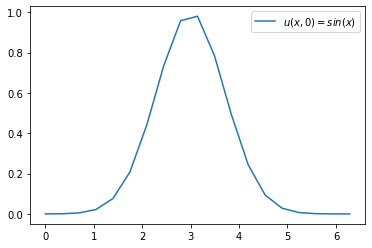

In [291]:
#u = np.sin(x_grid)
u = np.exp(-(x_grid-3)**2)
plt.plot(x_grid,u, label='$u(x,0)=sin(x)$')
plt.legend()
plt.show()

Obtaining local relevant SBP operators and resizing them over the whole grid with Kronecker products

In [293]:
#Local opretaros P and Q
P_LGL, Q_LGL = first_order_P_Q(x_Lagrange_nodes=x_LGL)

#Global operators P and Q
P = np.kron(np.eye(n_elements), P_LGL)
Q = np.kron(np.eye(n_elements), Q_LGL)

#Restriction operators R, B
#Local
R_LGL = np.zeros((2,n_nodes))
R_LGL[0,0] = R_LGL[-1,-1] = 1
B_LGL = np.zeros((2,2))
B_LGL[0,0] = 1; B_LGL[-1,-1]=-1
#Global
R = np.kron(np.eye(n_elements), R_LGL)
B = np.kron(np.eye(n_elements), B_LGL)

#Differential operator D
#Local
D_LGL = first_order_D(x_nodes=x_LGL)
#Global
D = np.kron(np.eye(n_elements), D_LGL)

#Numerical flux
#Local
f_num_loc = lambda uL, uR : c*uL
#Global
def f_num(u,n_elements=n_elements,n_nodes=n_nodes):
    #Fill numerical flux vector for first element
    #Using periodic BCs
    f = [c*u[-1],         #Left interface
         c*u[n_nodes-1]]  #Right interface
        #print(f"inside loop")
    #Iterate through first and
    for idx_elem in range(1,n_elements-1):
        #Left interface
        idx_R = idx_elem*n_nodes
        idx_L = idx_R-1
            #print(f"Element {idx_elem+1}")
            #print(f"Left interface")
            #print(f"{idx_L, idx_R}")

        f.append(f_num_loc(u[idx_L],u[idx_R]))
        
        #Right interface
        idx_R = (idx_elem+1)*n_nodes
        idx_L = idx_R-1
        #print(f"Right interface")
        #print(f"{idx_L, idx_R}")
        f.append(f_num_loc(u[idx_L],u[idx_R]))
    #Fill numerical flux vector for last element
    f.append(c*u[-n_nodes]) #Left interface
    f.append(c*u[-1])       #Right interface
        #print(f"Last element")
        #print(f"Left interface")
        #print(f"{-n_nodes-1, -n_nodes}")
        #print(f"Right interface")
        #print(f"{n_nodes*n_elements-1, 0}")
    return np.array(f)

#Vector and matrix with advection speed
c_vec = c*np.ones_like(u)
c_mat = c*np.eye(len(u))


def print_matrix(P):
    for i in range(len(P[0])):
        for j in range(len(P)):
            print(np.round(P[i,j],1),end=' ')
        print("")
    return None

Debugging cell:

In [294]:
#We define our grid (interface points will be repeated)
x_grid = np.zeros(n_elements*n_nodes)
for i in range(n_elements): 
    j = i*n_nodes
    x_grid[j:j+n_nodes] = x_element+x[i]
    #print(f"Element {i+1:}\t {x_grid[j:j+n_nodes]}")
    print(f"Element {i+1:}\t {j}   {j+n_nodes-1}")

Element 1	 0   2
Element 2	 3   5
Element 3	 6   8
Element 4	 9   11
Element 5	 12   14
Element 6	 15   17
Element 7	 18   20
Element 8	 21   23
Element 9	 24   26


Debugging cell:

In [252]:
f=f_num(u=u,n_elements=n_elements,n_nodes=n_nodes)
len(f)

18

Defining semi-discrete RHS operator

In [295]:
def RHS(t,u):
    split_form_interior = -0.5*D@c_mat@u -0.5*c_mat@D@u -0.5*np.diag(u)@D@c_vec
    elem_boundary_terms = -np.linalg.inv(P)@R.T@B@(f_num(u=u)-R@c_mat@u)
    return split_form_interior+elem_boundary_terms

Defining a time integrator for explicit  RK schemes

In [299]:
def RK(u0, A, b, c, dt, tfinal):
    n = len(u0)
    t = 0.0
    u = u0
    u_frames = [u0]
    while t < tfinal:
        k = np.zeros((n, len(c)))
        for j in range(len(c)):
            uj = u + dt*np.dot(k, A[j])
            k[:, j] = RHS(t,uj)#, t + c[j]*dt)
        u = u + dt*np.dot(k, b)
        u_frames.append(u)
        t = t + dt
    return u_frames

Using Heun's method with Butcher tableau

\begin{array}{c|ccc}
0   & 0   & 0   & 0    \\
1/3 & 1/3 & 0   & 0    \\
2/3 & 0   & 2/3 & 0    \\
\hline
    & 1/4 & 0   & 3/4  \\
\end{array}

In [300]:
A_Heun = np.array([[0., 0., 0.],
                   [1./3., 0., 0.],
                   [0., 2./3., 0.] ])
b_Heun = np.array([0.25, 0., 0.75])
c_Heun = np.array([0., 1./3., 2./3.])

Discretizing in time with custom RK integration

In [301]:
#For nonlinear fluxes the time step should be computed at each time inside the time integrator
dx = np.min(np.diff(x_grid[:n_nodes]))
CFL = 0.5
dt = CFL*c*dx
u_frames = RK(u0=u, A=A_Heun, b=b_Heun, c=c_Heun, dt=dt, tfinal=10.)

Plotting the solution

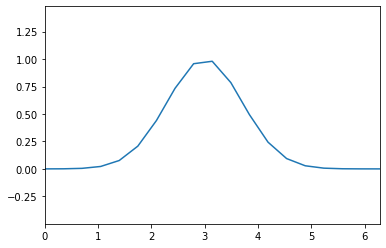

In [302]:
from matplotlib.animation import FuncAnimation

# Set up the figure and axis
fig, ax = plt.subplots()
ax.set_xlim(x_grid.min(), x_grid.max())
ax.set_ylim(u_frames[0].min()-0.5, u_frames[0].max()+0.5)
line, = ax.plot([], [])

def animate(i):
    y = u_frames[i]
    line.set_data(x_grid, y)
    return line,

import matplotlib
from matplotlib import animation
from IPython.display import HTML
anim = FuncAnimation(fig, animate,
                                   frames=len(u_frames),
                                   interval=200,
                                   repeat=False)
HTML(anim.to_jshtml())